In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.sort()
sys.path.reverse()
try:
    sys.path.remove('../MEVA')
except:
    pass
sys.path.append('../MEVA')
sys.path

['/home/tormod/anaconda3/envs/apec/lib/python36.zip',
 '/home/tormod/anaconda3/envs/apec/lib/python3.6/site-packages',
 '/home/tormod/anaconda3/envs/apec/lib/python3.6/lib-dynload',
 '/home/tormod/anaconda3/envs/apec/lib/python3.6',
 '/home/tormod/.local/lib/python3.6/site-packages/IPython/extensions',
 '/home/tormod/.local/lib/python3.6/site-packages',
 '/home/tormod/.ipython',
 '',
 '../MEVA']

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import mmcv
from PIL import Image
from tqdm.auto import tqdm, trange
import os
import glob

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = torchvision.transforms.functional.to_pil_image(inp)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [6]:
vid_file = 'videos/IMG_2139.MOV'
vid = mmcv.video.VideoReader(vid_file)

In [7]:
#from data import VideoFrameFolder
# data_transforms = {
#     'train': transforms.Compose([
#         #transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.ToTensor(),
#         #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }


# val_dataset = VideoFrameFolder('/home/tormod/ucph-erda-home/frames/',
#                               transform=data_transforms['val'])
# val_dataloader = torch.utils.data.DataLoader(val_dataset,
#                                             batch_size=30,
#                                             shuffle=False,
#                                             num_workers=8)

## MMTracking

In [8]:
import mmtrack
import bbox
from mmtrack.apis import init_model

In [9]:
track_model = init_model('../mmtracking/configs/mot/tracktor/tracktor_faster-rcnn_r50_fpn_4e_mot17-private.py')
#track_model = init_model('../mmtracking/configs/vid/selsa/selsa_faster_rcnn_r50_dc5_1x_imagenetvid.py')
#track_model = init_model('../mmtracking/configs/vid/dff/dff_faster_rcnn_r50_dc5_1x_imagenetvid.py')

2021-03-30 10:55:45,644 - mmtrack - INFO - load detector from: https://download.openmmlab.com/mmtracking/mot/faster_rcnn/faster-rcnn_r50_fpn_4e_mot17-ffa52ae7.pth
2021-03-30 10:55:45,735 - mmtrack - INFO - load reid from: https://download.openmmlab.com/mmtracking/mot/reid/tracktor_reid_r50_iter25245-a452f51f.pth


In [40]:
bboxes = bbox.detect_mot(track_model, vid, only_first=10)

In [41]:
bboxes

array([[ 249.6385498 ,  309.82116699,  592.1015625 ,  999.64440918],
       [ 267.03833008,  353.39727783,  530.45184326, 1016.62249756],
       [ 257.92556763,  296.45965576,  576.74005127, 1015.6081543 ],
       [ 251.95495605,  314.40621948,  584.53771973, 1005.74194336],
       [ 261.76220703,  278.49612427,  580.01696777, 1022.12658691],
       [ 259.10678101,  354.69360352,  513.4440918 , 1013.15393066],
       [ 254.71783447,  357.01443481,  503.9649353 , 1020.67352295],
       [ 254.00553894,  360.86737061,  501.20315552, 1024.5567627 ],
       [ 259.67425537,  247.32427979,  582.21124268, 1023.52685547],
       [ 259.93386841,  252.25010681,  581.39978027, 1027.79882812]])

In [25]:
#mmcv.frames2video('tmp_frames', 'zoom_test.mp4', fps=vid.fps)

/home/tormod/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


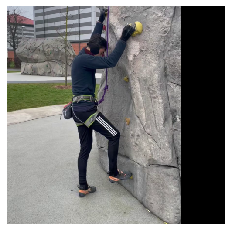

In [43]:
imshow(bbox.bbox_crop(vid[0], bboxes[0]))

# MMPose HMR

In [13]:
from mmpose.apis import init_pose_model
from mesh import inference_mesh_model, get_vertices
from meva.utils.demo_utils import convert_crop_cam_to_orig_img
from meva.utils.renderer import Renderer

../MEVA/meva/utils/transformations.py:1927: UserWarning: No module named 'meva.utils._transformations'
  warnings.warn(str(err))


In [14]:
pose_model = init_pose_model('mmpose/configs/hmr_res50_224x224.py',
                             'mmpose/models/pytorch/hmr/hmr_mesh_224x224-c21e8229_20201015.pth')

In [15]:
frame_id = 9

pose_model.eval()
person_results = [dict(bbox=bboxes[frame_id])]
_, res = inference_mesh_model(pose_model, 
                              vid[frame_id], 
                              person_results,
                              format='xyxy')
verts = get_vertices(pose_model, res)

orig_height, orig_width, _ = vid[frame_id].shape
print(bboxes[frame_id])
bbox_xywh = bbox.xyxy2xywh(bboxes[np.newaxis,frame_id])[0]
center, scale = bbox.box2cs(bbox_xywh, (orig_height, orig_width))
print(bbox_xywh)
bbox_csh = np.concatenate((center, scale))[np.newaxis]
bbox_csh[:,2] = bbox_xywh[3]
print(bbox_csh)
orig_cam = convert_crop_cam_to_orig_img(res['cam'], bbox_csh, orig_width, orig_height)


renderer = Renderer(resolution=(orig_width, orig_height), orig_img=True)
img = renderer.render(vid[frame_id], verts[0], orig_cam[0])

[-182.41888428 -166.50440979  529.81182861 1502.37158203]
[-182.41888428 -166.50440979  713.23071289 1669.87599182]
[[ 174.19647   668.4336   1669.876      10.436725]]


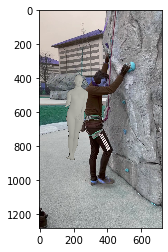

In [16]:
plt.imshow(img)